In [28]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class TeleportDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset=None, shape=(3,128,128)):
        transform = T.Compose((
            T.ColorJitter(0.2,0.2,0.2,0.2),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.ToTensor(),
            T.Lambda(lambda x: F.group_norm(x, 1))
        ))
        
        self.dataset = dataset or torchvision.datasets.CIFAR10(root="/tmp", download=True, transform=transform)
        self.shape = shape
        self.object_shape = self.dataset[0][0].shape
        assert self.shape[0] == self.object_shape[0]
    
    def __iter__(self):
        return self
        
    def __next__(self):
        image,*_ = self.dataset[torch.randint(len(self.dataset),()).item()]
        ic,ih,iw = self.shape
        oc,oh,ow = self.object_shape
        target = torch.zeros(ic,ih,iw,dtype=torch.long)
        mx1,my1 = torch.randint(iw//2-ow-2,()).item(), torch.randint(ih-oh-2,()).item()
        target[:,my1-2:oh+my1+2,mx1-2:mx1+ow+2] = 1
        target[:,my1-1:oh+my1+1,mx1-1:mx1+ow+1] = -1
        target[:,my1:oh+my1,mx1:mx1+ow] = 0
        
        mx2,my2 = iw//2+torch.randint(iw//2-ow-2,()).item(), torch.randint(ih-oh-2,()).item()
        target[:,my2-2:oh+my2+2,mx2-2:mx2+ow+2] = 1
        target[:,my2-1:oh+my2+1,mx2-1:mx2+ow+1] = -1
        target[:,my2:oh+my2,mx2:mx2+ow] = 0
        
        challenge = target.clone()
        if torch.randn(1) > 0:
            challenge[:,my1:oh+my1,mx1:mx1+ow] = image
            target[:,my2:oh+my2,mx2:mx2+ow] = image
        else:
            target[:,my1:oh+my1,mx1:mx1+ow] = image
            challenge[:,my2:oh+my2,mx2:mx2+ow] = image
            
        return challenge, target
        

Files already downloaded and verified


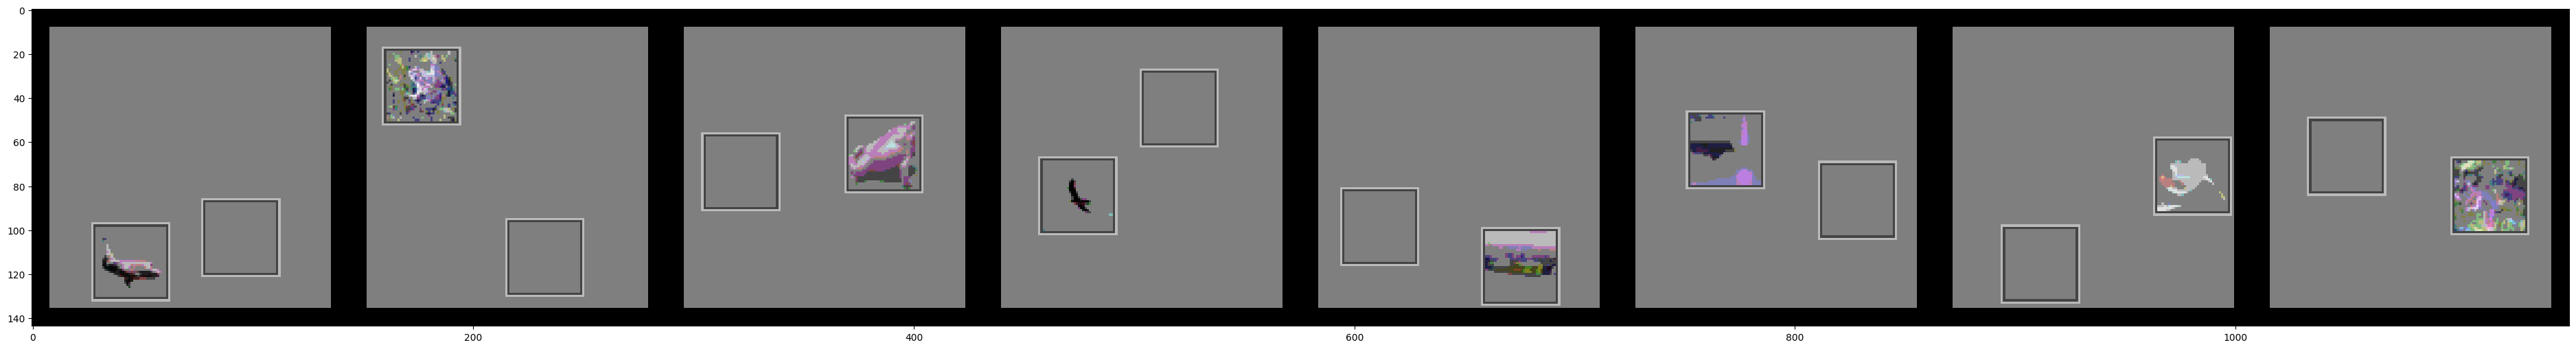

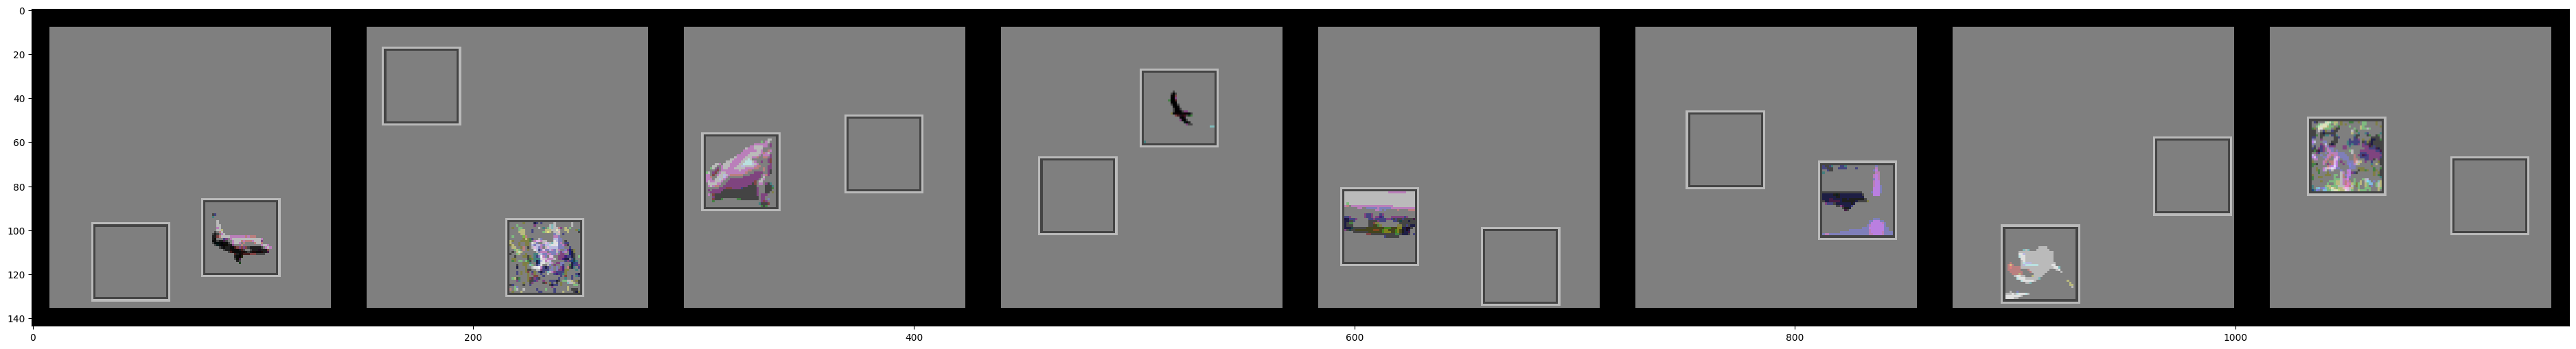

In [29]:
dataset = TeleportDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))
batch = batch.sigmoid()
target = target.sigmoid()
batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).numpy(), cmap="nipy_spectral")
plt.show()
